# Usage Data Stage 2, Parsed Data + WE to Pytorch Geometric data batch!

In [266]:
%load_ext autoreload
%autoreload 2
## util
import os
import logging
from argparse import ArgumentParser
from tqdm import tqdm_notebook as tqdmnb
from tqdm import tqdm as tqdm
import pickle
import json 
import jsonlines as jsonl
## graph
import networkx as nx
import matplotlib.pyplot as plt
## nn
import numpy as np
import torch
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data.data import Data
from torch_geometric.data import DataLoader
## model
import stanza
from stanza.models.common.doc import Document

## self
import config
from config import nli_config 
import utils
from model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
glove_data = utils.load_glove_vector()
glove, words, word2idx, idx = glove_data

In [103]:
print(idx)

1917496


In [70]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

2020-08-04 18:36:17 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-08-04 18:36:17 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-08-04 18:36:17 INFO: Use device: gpu
2020-08-04 18:36:17 INFO: Loading: tokenize
2020-08-04 18:36:17 INFO: Loading: pos
2020-08-04 18:36:18 INFO: Loading: lemma
2020-08-04 18:36:19 INFO: Loading: depparse
2020-08-04 18:36:20 INFO: Done loading processors!


In [2]:
config.PDEV_MA_FILE

PosixPath('/work/2020-IIS-NLU-internship/MNLI/data/MNLI_Stanza/pre_multinli_1.0_dev_matched.jsonl')

In [20]:
with open(config.PDEV_MA_FILE, "r") as fo:
    dataset = fo.readlines()
    dataset = [utils.json.loads(raw_data) for raw_data in dataset]

In [23]:
exp1 = dataset[0]

In [24]:
h1 = exp1[config.hf]

In [31]:
h1[0][0].keys()

dict_keys(['id', 'text', 'lemma', 'upos', 'xpos', 'feats', 'head', 'deprel', 'misc'])

In [35]:
print(h1[0][0]['id'], h1[0][0]['deprel'], h1[0][0]['head'])

1 nsubj 3


In [36]:
print(h1[0][0])

{'id': '1', 'text': 'Everyone', 'lemma': 'everyone', 'upos': 'PRON', 'xpos': 'NN', 'feats': 'Number=Sing', 'head': 3, 'deprel': 'nsubj', 'misc': 'start_char=0|end_char=8'}


In [45]:
Document(h1).sentences[0].print_dependencies()

('Everyone', '3', 'nsubj')
('really', '3', 'advmod')
('likes', '0', 'root')
('the', '6', 'det')
('newest', '6', 'amod')
('benefits', '3', 'obj')


In [49]:
doc1 = Document(h1)

In [56]:
# old version parse + build graph at the same time
def doc2graph(doc, word2idx=None):
    """
    2020/8/4 18:30
    input Stanza Document : doc
    output PytorchGeoData : G
    G = {
     x: id tensor
     edge_idx : edges size = (2, l-1)
     edge_attr: (u, v, edge_type in str)
     node_attr: text
    }
    """
    # add root token for each sentences
    e = [[],[]]
    edge_info = []
    node_info = []
    prev_token_sum = 0
    prev_root_id = 0
    cur_root_id = 0
    # get original dependency
    for idx, sent in enumerate(doc.sentences):
        sent.print_dependencies
        # node info by index(add root at the beginning of every sentence)
        cur_root_id = len(node_info)
        node_info.append("[ROOT]")
        for token in sent.tokens:
            node_info.append(token.to_dict()[0]['text'])
        # edge info by index of u in edge (u,v)
        for dep in sent.dependencies:
            id1 = prev_token_sum + int(dep[0].to_dict()["id"])
            id2 = prev_token_sum + int(dep[2].to_dict()["id"])
            e[0].append(id1)
            e[1].append(id2)
            edge_info.append((id1, id2, dep[1]))
        prev_token_sum += len(sent.tokens)+1
        # add links between sentence roots
        if(cur_root_id != 0):
            id1 = prev_root_id
            id2 = cur_root_id
            e[0].append(id1)
            e[1].append(id2)
            edge_info.append((id1, id2, "bridge"))
        prev_root_id = cur_root_id
    # id to embeddings
    # x = torch.tensor([ for token in node_attr])
    # done building edges and nodes
    if word2idx == None:
        x = torch.tensor(list(range(doc.num_tokens+len(doc.sentences))))
    else:
        x = torch.tensor([ word2idx[token] if token in word2idx.keys() else word2idx["[UNK]"] for token in node_info])
    e = torch.tensor(e)
    G = Data(x=x, edge_index=e, edge_attr=edge_info, node_attr=node_info)
    return G

In [65]:
g1 = utils.doc2graph(doc1)
g1

Data(edge_attr=[6], edge_index=[2, 6], node_attr=[7], x=[7])

In [62]:
g1.edge_attr

[(3, 1, 'nsubj'),
 (3, 2, 'advmod'),
 (0, 3, 'root'),
 (6, 4, 'det'),
 (6, 5, 'amod'),
 (3, 6, 'obj')]

[0, 1, 2, 3, 4, 5, 6]
[(0, 3), (3, 1), (3, 2), (3, 6), (6, 4), (6, 5)]


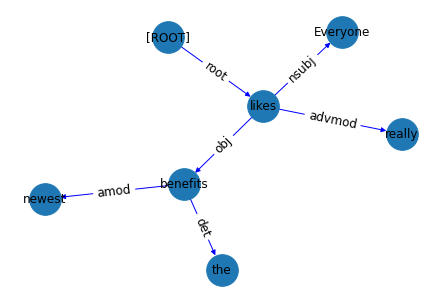

In [66]:
utils.draw(g1)

In [67]:
ANLI_example = "Kwon So-hyun (born August 30, 1994), is a South Korean singer and actress. She was known as a member of the South Korean girl group 4Minute, under Cube Entertainment. She is also a former member of the South Korean girl group, Orange. Before June 15, 2016 (end of her contract with Cube), Sohyun left 4Minute and the record label along with members Nam Ji-hyun, Heo Ga-yoon, and Jeon Ji-yoon."

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
[(0, 15), (0, 19), (1, 2), (1, 4), (4, 3), (4, 5), (5, 6), (5, 7), (5, 8), (5, 9), (15, 1), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 17), (15, 18), (17, 16), (19, 22), (19, 39), (22, 20), (22, 21), (22, 25), (22, 38), (25, 23), (25, 24), (25, 31), (25, 34), (25, 37), (31, 26), (31, 27), (31, 28), (31, 29), (31, 30), (31, 33), (33, 32), (37, 35), (37, 36), (39, 45), (39, 55), (45, 40), (45, 41), (45, 42), (45, 43), (45, 44), (45, 51), (45, 54), (50, 49), (51, 46), (51, 47), (51, 48), (51, 50), (51, 52), (51, 53), (55, 71), (57, 56), (57, 58), (57, 59), (57, 60), (57, 62), (62, 61), (62, 65), (62, 68), (65, 63

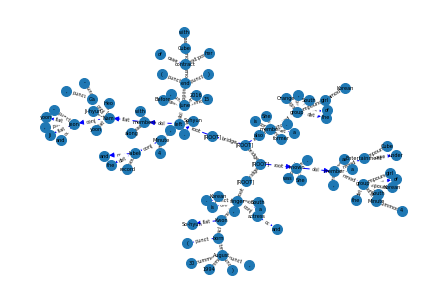

In [78]:
g2 = utils.text2graph(ANLI_example, nlp)
utils.draw(g2, node_size=100, font_size=5, save_img_file="anli_demo_graph")

In [81]:
import model

In [107]:
glove[word2idx["good"]]@glove[word2idx["nice"]]

tensor(41.1199)

In [105]:
glove[word2idx["good"]]@glove[word2idx["bad"]]

tensor(37.2005)

# Complex Example for Data Batching

In [87]:
class PairData(Data):
    def __init__(self, edge_index_s, x_s, edge_index_t, x_t):
        super(PairData, self).__init__()
        self.edge_index_s = edge_index_s
        self.x_s = x_s
        self.edge_index_t = edge_index_t
        self.x_t = x_t
    def __inc__(self, key, value):
        if key == 'edge_index_s':
            return self.x_s.size(0)
        if key == 'edge_index_t':
            return self.x_t.size(0)
        else:
            return super(PairData, self).__inc__(key, value)

In [109]:
edge_index_s = torch.tensor([
    [0, 0, 0, 0],
    [1, 2, 3, 4],
])
x_s = torch.randn(5, 16)  # 5 nodes.
edge_index_t = torch.tensor([
    [0, 0, 0],
    [1, 2, 3],
])
x_t = torch.randn(4, 16)  # 4 nodes.

data = PairData(edge_index_s, x_s, edge_index_t, x_t)
data_list = [data, data]
loader = DataLoader(data_list, batch_size=2)
batch = next(iter(loader))

print(batch)
print(batch.edge_index_s)
print(batch.edge_index_t)
print(batch.batch)

Batch(edge_index_s=[2, 8], edge_index_t=[2, 6], x_s=[10, 16], x_t=[8, 16])
tensor([[0, 0, 0, 0, 5, 5, 5, 5],
        [1, 2, 3, 4, 6, 7, 8, 9]])
tensor([[0, 0, 0, 4, 4, 4],
        [1, 2, 3, 5, 6, 7]])
None


In [110]:
loader = DataLoader(data_list, batch_size=2, follow_batch=['x_s', 'x_t'])
batch = next(iter(loader))
print(batch.x_s_batch)

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


# My Data Set

In [201]:
class GraphData(Data):
    """
    item is a raw json of parsed result
    """
    def __init__(self, data, word2idx, tolower=True):
        super(GraphData, self).__init__()
        g_p = utils.doc2graph(Document(data[config.pf]))
        g_h = utils.doc2graph(Document(data[config.hf]))
        self.edge_index_p = g_p.edge_index
        #print(g_p.node_attr)
        self.x_p = torch.tensor([ word2idx[w.lower()] for w in g_p.node_attr], dtype=torch.long)
        self.edge_index_h = g_h.edge_index
        self.x_h = torch.tensor([ word2idx[w.lower()] for w in g_h.node_attr], dtype=torch.long)
        self.label = data[config.lf]
        self.pid = data[config.idf]
    def __inc__(self, key, value):
        if key == 'edge_index_p':
            return self.x_p.size(0)
        if key == 'edge_index_h':
            return self.x_h.size(0)
        else:
            return super(PairData, self).__inc__(key, value)

In [198]:
import data

In [182]:
dev_jdata = data.load_jdata(data_file=config.PDEV_MA_FILE)
test_jdata = data.load_jdata(data_file=config.PDEV_MMA_FILE)

In [183]:
expdata = dev_jdata[0]

In [184]:
from collections import defaultdict

In [185]:
dd = defaultdict(int)
dd["why"]

0

In [199]:
gdata1 = GraphData(expdata, word2idx)

In [202]:
print(gdata1.edge_index_p, gdata1.edge_index_h, gdata1.label, gdata1.pid)
print(gdata1.x_p, gdata1.x_h)

tensor([[3, 3, 6, 6, 6, 0],
        [1, 2, 3, 4, 5, 6]]) tensor([[3, 3, 0, 6, 6, 3],
        [1, 2, 3, 4, 5, 6]]) 1 63735n
tensor([  0,   3,  57, 688,  26, 425, 401]) tensor([   1,    0,  154, 1044,    3, 3949, 1246])


In [204]:
print(utils.doc2graph(expdata[config.hf]).node_attr)
print(utils.doc2graph(expdata[config.pf]).node_attr)

['[ROOT]', 'Everyone', 'really', 'likes', 'the', 'newest', 'benefits']
['[ROOT]', 'The', 'new', 'rights', 'are', 'nice', 'enough']


[0, 1, 2, 3, 4, 5, 6]
[(0, 6), (3, 1), (3, 2), (6, 3), (6, 4), (6, 5)]


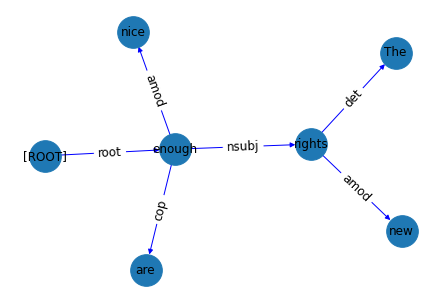

None


In [150]:
utils.draw(utils.doc2graph(Document(expdata[config.pf])))
print(Document(expdata[config.pf]).text)

In [232]:
dev_data_set = [data.GraphData(item, word2idx) for item in dev_jdata]

In [243]:
loader = DataLoader(dev_data_set, batch_size=3, follow_batch=['x_p', 'x_h'])

In [244]:
batch = next(iter(loader))

In [245]:
batch.x_p_batch

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])

In [246]:
batch.label

tensor([1, 0, 2])

In [247]:
batch.pid

['63735n', '91383c', '755e']

In [248]:
# try a batch
print(batch.edge_index_p, batch.edge_index_h, batch.label, batch.pid, sep='\n')
print(batch.x_p, batch.x_h, sep='\n')
print(batch.x_p_batch, batch.x_h_batch, sep='\n')

tensor([[ 3,  3,  6,  6,  6,  0,  9, 10,  7, 12, 10, 16, 16, 16, 12, 20, 20, 20,
         12, 24, 24, 24, 20, 10, 31, 31, 31, 31, 26, 35, 35, 35, 31, 35, 38, 36,
         42, 42, 42, 31, 42, 50, 48, 48, 48, 50, 50, 31, 52, 50, 54, 52, 54],
        [ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
         39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]])
tensor([[ 3,  3,  0,  6,  6,  3, 11, 11, 11, 18, 11, 15, 15, 12, 18, 18,  7, 21,
         21, 18, 18, 25, 23, 25, 30, 30, 30, 25, 35, 35, 35, 35, 25, 35, 38, 36,
         38, 25],
        [ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
         39, 40]])
tensor([1, 0, 2])
['63735n', '91383c', '755e']
tensor([    0,     3,    57,   688,    26,   425,   401,     0,    24,   213,
          707,     8,   300,     

In [251]:
obj = type('',(object,),{"foo": 1})()

In [253]:
obj.foo

1

In [254]:
type(obj)

__main__.

In [277]:
config.nli_config.hidden_size

300

In [278]:
import config

In [279]:
nli_config.embedding

'glove300d'